In [3]:
!pip install -q kagglehub

In [4]:
import kagglehub

# Descarga directa del dataset (usando KaggleHub API)
path = kagglehub.dataset_download("pratyushpuri/retail-fashion-boutique-data-sales-analytics-2025")

print("✅ Dataset descargado en:", path)

100%|██████████| 295k/295k [00:00<00:00, 58.6MB/s]

Extracting files...
✅ Dataset descargado en: /root/.cache/kagglehub/datasets/pratyushpuri/retail-fashion-boutique-data-sales-analytics-2025/versions/1


In [5]:
import os
os.listdir(path)

['fashion_boutique_dataset.xlsx',
 'fashion_boutique_dataset.db',
 'fashion_boutique_dataset.csv',
 'fashion_boutique_dataset.json']

In [8]:
from pathlib import Path
import pandas as pd
import json

root = Path(path)  # carpeta devuelta por kagglehub
# Buscar recursivamente archivos JSON o CSV
candidatos = list(root.rglob("*.json")) + list(root.rglob("*.csv"))
print("Archivos encontrados:", [p.name for p in candidatos])

if not candidatos:
    raise FileNotFoundError("No se encontraron JSON/CSV dentro del dataset.")

# Elegimos uno con 'sales' en el nombre si existe; si no, el primero
pick = next((p for p in candidatos if "sales" in p.stem.lower()), candidatos[0])
print("Usando archivo:", pick)

# Cargar según extensión y formato
if pick.suffix.lower() == ".csv":
    df = pd.read_csv(pick)
else:
    # Intento 1: JSON lines (NDJSON)
    try:
        df = pd.read_json(pick, lines=True)
    except ValueError:
        # Intento 2: lista de dicts o dict con clave que contiene la lista
        with open(pick, "r", encoding="utf-8") as f:
            obj = json.load(f)
        if isinstance(obj, list):
            df = pd.DataFrame(obj)
        elif isinstance(obj, dict):
            # Buscar la primera clave que sea lista de registros
            lista = None
            for v in obj.values():
                if isinstance(v, list):
                    lista = v
                    break
            if lista is not None:
                df = pd.DataFrame(lista)
            else:
                # Como última opción, normalizar el dict
                df = pd.json_normalize(obj)
        else:
            raise ValueError("Formato JSON no reconocido.")

print("Shape:", df.shape)
display(df.head())

Archivos encontrados: ['fashion_boutique_dataset.json', 'fashion_boutique_dataset.csv']
Usando archivo: /root/.cache/kagglehub/datasets/pratyushpuri/retail-fashion-boutique-data-sales-analytics-2025/versions/1/fashion_boutique_dataset.json
Shape: (2176, 14)


,product_id,category,brand,season,size,color,original_price,markdown_percentage,current_price,purchase_date,stock_quantity,customer_rating,is_returned,return_reason
0,FB000001,Outerwear,Zara,Spring,XL,Red,196.01,0.0,196.01,2025-07-05T00:00:00.000,37,3.0,False,None
1,FB000002,Tops,Uniqlo,Winter,L,Pink,119.64,0.0,119.64,2025-08-06T00:00:00.000,2,2.5,False,None
2,FB000003,Accessories,Uniqlo,Winter,None,Black,33.80,0.0,33.80,2025-08-06T00:00:00.000,22,4.3,False,None
3,FB000004,Shoes,Uniqlo,Spring,XL,Black,75.36,0.0,75.36,2025-07-07T00:00:00.000,48,2.6,False,None
4,FB000005,Tops,Banana Republic,Winter,XL,Black,105.02,0.0,105.02,2025-08-06T00:00:00.000,10,NaN,False,None


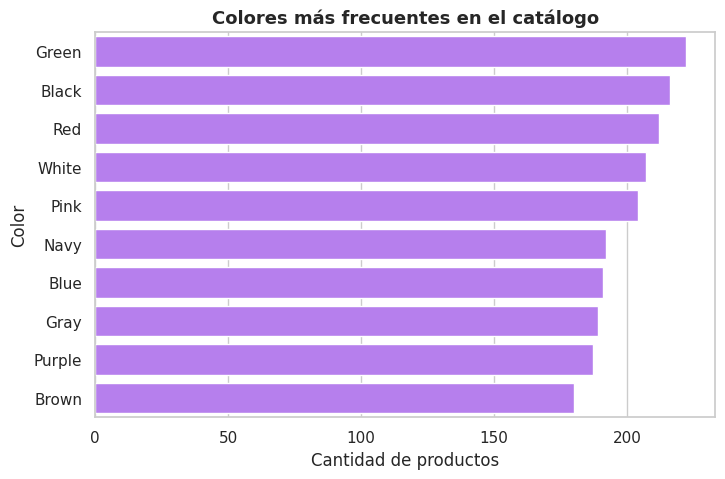

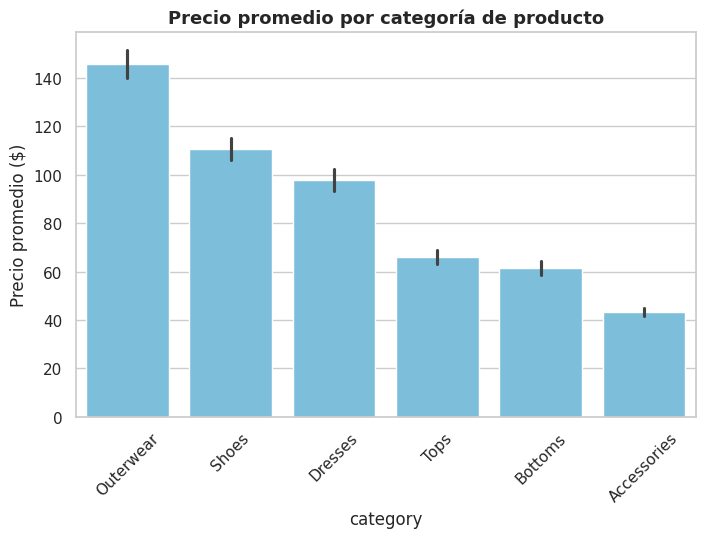

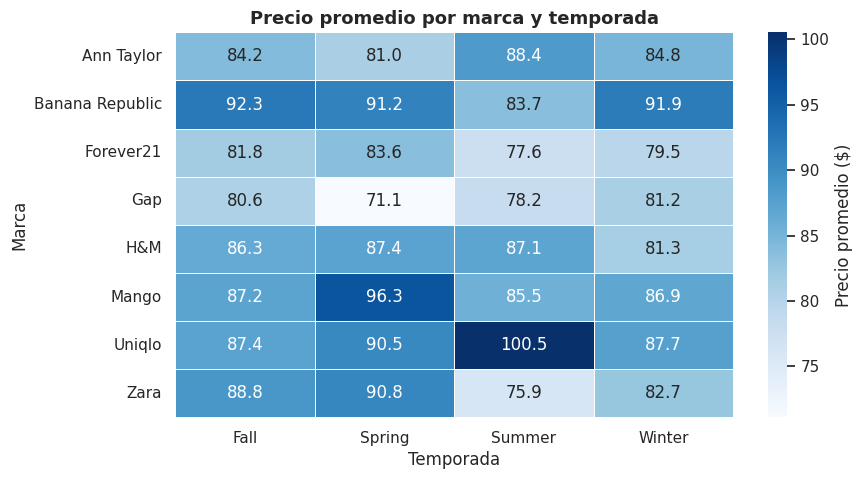

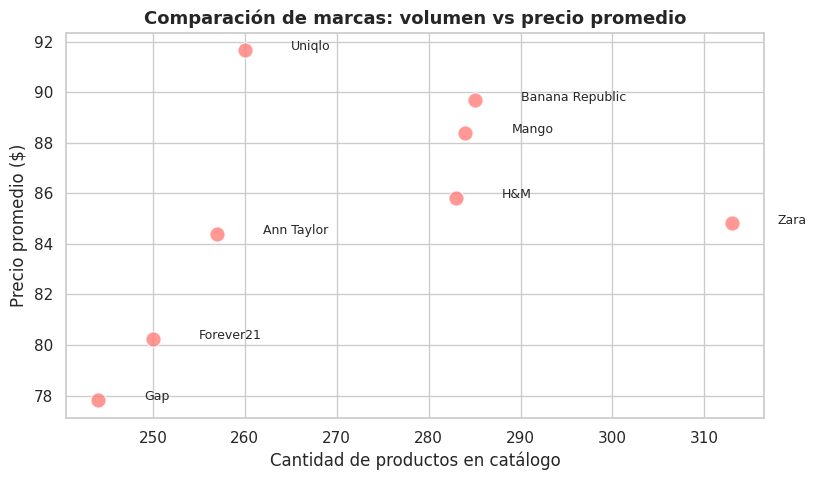

💡 Insight general:
- El color más predominante es **Green**, lo que refleja la tendencia hacia tonos neutros o clásicos.
- La categoría con mayor precio promedio es **Outerwear**, asociada a productos de mayor valor percibido.
- La marca con más artículos es **Zara**, mientras que la más premium es **Uniqlo**.
- El precio promedio general ronda los **$85.50**.

El análisis evidencia una clara segmentación por marca: algunas priorizan variedad (volumen), mientras que otras se enfocan en posicionamiento premium. Estas diferencias sugieren estrategias comerciales diversas según el público objetivo.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid", palette="cool")

# --- 1. Colores más utilizados (Top 10) ---
plt.figure(figsize=(8,5))
color_counts = df['color'].value_counts().head(10)
sns.barplot(y=color_counts.index, x=color_counts.values, orient='h', color="#B66DFF")
plt.title("Colores más frecuentes en el catálogo", fontsize=13, weight='bold')
plt.xlabel("Cantidad de productos")
plt.ylabel("Color")
plt.show()

# --- 2. Precio promedio por categoría ---
plt.figure(figsize=(8,5))
order = df.groupby('category')['current_price'].mean().sort_values(ascending=False).index
sns.barplot(data=df, x='category', y='current_price', order=order, color="#6EC5E9")
plt.title("Precio promedio por categoría de producto", fontsize=13, weight='bold')
plt.xticks(rotation=45)
plt.ylabel("Precio promedio ($)")
plt.show()

# --- 3. Mapa de calor: precio promedio por marca y temporada ---
plt.figure(figsize=(9,5))
pivot = df.pivot_table(values='current_price', index='brand', columns='season', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Precio promedio ($)'})
plt.title("Precio promedio por marca y temporada", fontsize=13, weight='bold')
plt.xlabel("Temporada")
plt.ylabel("Marca")
plt.show()

# --- 4. Comparación entre marcas (volumen y precio promedio) ---
plt.figure(figsize=(9,5))
brand_stats = df.groupby('brand').agg({'product_id':'count','current_price':'mean'}).sort_values(by='product_id', ascending=False).head(10)
sns.scatterplot(data=brand_stats, x='product_id', y='current_price', s=120, color="#FF7E79", alpha=0.8)
for i in brand_stats.index:
    plt.text(brand_stats.loc[i,'product_id']+5, brand_stats.loc[i,'current_price'], i, fontsize=9)
plt.title("Comparación de marcas: volumen vs precio promedio", fontsize=13, weight='bold')
plt.xlabel("Cantidad de productos en catálogo")
plt.ylabel("Precio promedio ($)")
plt.show()

# --- Insight final ---
top_color = color_counts.index[0]
top_cat = df.groupby('category')['current_price'].mean().idxmax()
top_brand = brand_stats.index[0]
premium_brand = brand_stats['current_price'].idxmax()
avg_price = df['current_price'].mean()

print(f"💡 Insight general:\n"
      f"- El color más predominante es **{top_color}**, lo que refleja la tendencia hacia tonos neutros o clásicos.\n"
      f"- La categoría con mayor precio promedio es **{top_cat}**, asociada a productos de mayor valor percibido.\n"
      f"- La marca con más artículos es **{top_brand}**, mientras que la más premium es **{premium_brand}**.\n"
      f"- El precio promedio general ronda los **${avg_price:.2f}**.\n\n"
      f"El análisis evidencia una clara segmentación por marca: algunas priorizan variedad (volumen), "
      f"mientras que otras se enfocan en posicionamiento premium. "
      f"Estas diferencias sugieren estrategias comerciales diversas según el público objetivo.")